# Part I: Counting Objects

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import data, img_as_float
from skimage.exposure import equalize_hist
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.morphology import closing, remove_small_objects
from skimage.measure import regionprops, label
from skimage.color import label2rgb

We are interested in detecting the coins in skimage.data.coins and determining their area and eccentricity. First, we load in the coins image in a floating point format with values between 0 and 1 using skimage.img_as_float. In order to increase the global constrast of the image, we equalize the coins image using skimage.exposure.equalize_hist. Following this, we can apply a threshold_otsu filter to the equalized image to convert it into a binary format. Here we threshold on 1.3 times the Otsu 'optimal' threshold, so we don't loose any coins while generating the thresholded image. We then use skimage.segmentation.clear_border to clear any objects connected to the image border before taking the morphological closing of the image. Next we can remove any small connected components from the image using skimage.morphology.remove_small_objects. Last, we label the connected regions of the image using skimage.measure.label, which can then be visualized with color-coded labels using skimage.color.label2rgb.

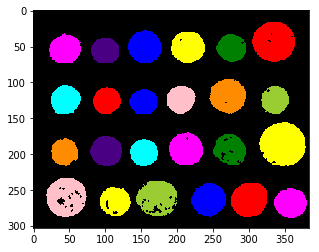

In [2]:
#load in the coins image
img_coins = img_as_float(data.coins())

#improve contrast by equalizing the coin image
eq_coins = equalize_hist(img_coins)

#apply Otsu's threshold to the coin image
thresh_coins = threshold_otsu(eq_coins)
binary_coins = eq_coins >= 1.3 * thresh_coins #we scale by 1.3 so we don't loose any coins

#clear the binary image's border
binary_coins_border = clear_border(binary_coins)

#take morphological closing of image
binary_coins_close = closing(binary_coins_border)

#remove any small objects 
coins_cleaned = remove_small_objects(binary_coins_close)

#label the connected regions of the image and create color-coded labeled image
binary_coins_regions = label(coins_cleaned)
coins_label = label2rgb(binary_coins_regions, bg_label = 0, bg_color = (0,0,0))

#visualize the connected regions using color-coded labels
plt.imshow(coins_label)

Next, we calculate the area and eccentricity of each labeled connected region in the image, i.e. each coin. We achieve this by looping over the properties of each labeled region using skimage.measure.regionprops. If a labeled region has an area large enough to be a coin, we calculate that region's area, eccentricity, and centroid position. Then we can place text over the centroid of that region in the original image, indicating the coin's area and eccentricity. The result is then displayed.

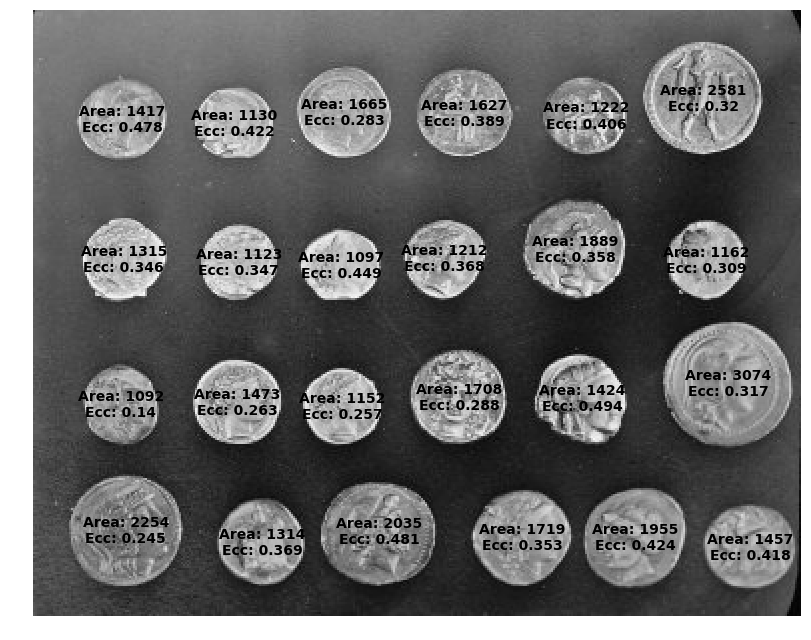

In [3]:
#create a figure and axis
fig, ax = plt.subplots(figsize = (15, 9))

#show original coin image
ax.imshow(img_coins, cmap = 'gray')

#loop over the properties of labeled regions
for region in regionprops(binary_coins_regions):
    
    #check if the region is big enough to be a coin
    if region.area >= 100:
        
        #compute centroid, area and eccentricity of coin, display info in text over coin image
        cent = region.centroid
        area = region.area
        ecc = round(region.eccentricity, 3)
        ax.text(cent[1], cent[0], 'Area: ' + str(area) + '\n' + 'Ecc: ' + str(ecc), fontsize = 14,
                horizontalalignment='center', verticalalignment='center', color = 'black',
                fontdict = {'family': 'sans-serif', 'weight': 'bold'})

#turn off axis lines/labels and use tight layout     
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Part II: Panorama Stitching

Next, we want to try to stitch together three photos to make a panorama. We will use three overlapping photos taken looking out over the bay towards San Francisco and the Golden Gate Bridge with the Advanced Light Source synchrotron in the foreground. We will follow the steps taken in the tutorial: [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

In [4]:
import skimage.io as io
from skimage.color import rgb2gray
from skimage.feature import ORB
from skimage.feature import match_descriptors
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.graph import route_through_array
from skimage.color import gray2rgb

First, we define a function that will simply allow us to plot the three images side-by-side. We will call this function compare_images( ).

In [5]:
def compare_images(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin = 1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation = 'nearest', cmap = 'gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

Next, we use skimage.io.ImageCollection to load in the images, where we use a wildcard to collect the three .png files. We then convert the three images to a grayscale format using skimage.color.rgb2gray. We also display the three color images so we can see what we will be stitching together.

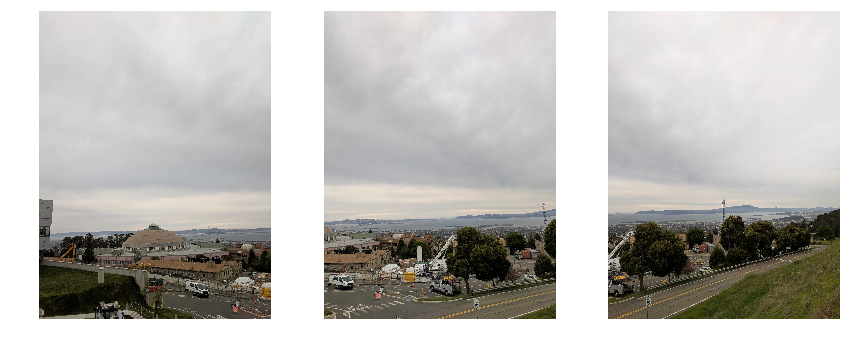

In [6]:
#load in the three images using .ImageCollection()
#the path in ImageCollection() should match the location of the image files to be stitched
bay_imgs = io.ImageCollection('/Users/danslaughter/Desktop/AY250/hw7/*.png')

#convert the three images to grayscale
sf_bay0, sf_bay1, sf_bay2 = [rgb2gray(image) for image in bay_imgs]

#view the three color images
compare_images(*bay_imgs, figsize = (12, 10))

Next, we want to relate the three images to one another so they can be joined together in a suitable way. We will do this by 'anchoring' one image and warping the other two images to match the perspective of the anchor image and then match the features of the two images to the anchor. We will use the center image, sf_bay1, as the anchor. We will use skimage's ORB function (Oriented FAST and rotated BRIEF) to detect the features in the images. Once we've detect the image features, we then match the features between sf_bay0 and sf_bay1, and sf_bay1 and sf_bay2 using skimage.feature.match_descriptors. 

In [7]:
#initialize ORB - we will use 1000 keypoints 
orb = ORB(n_keypoints = 1000, fast_threshold = 0.05)

#detect keypoints in sf_bay0, sf_bay1, and sf_bay2
orb.detect_and_extract(sf_bay0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

orb.detect_and_extract(sf_bay1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

orb.detect_and_extract(sf_bay2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

#match the features between sf_bay0/sf_bay2 images and the sf_bay1
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

Since there are many false matches between features, we will want to filter these out to ensure the images line up properly. To achieve this, we use RANSAC (RANdom SAmple Consensus). First we filter false matches between sf_bay0 and sf_bay1, and then filter the false matches between sf_bay1 and sf_bay2.

In [8]:
#select keypoints from image to be registered (sf_bay0) and anchor image (sf_bay1)
src = keypoints0[matches01[:, 0]][:, ::-1]
dst = keypoints1[matches01[:, 1]][:, ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples = 4, residual_threshold = 1, max_trials = 1000)

#select keypoints from image to be registered (sf_bay2) and anchor image (sf_bay1)
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples = 4, residual_threshold = 1, max_trials = 1000)

Now we want to warp the images sf_bay0 and sf_bay2 to match the perspective of the anchor image sf_bay1 and align them suitably to form a panorama. First we determine the shape of the output image that will contain the warped and anchor images by determining the extent of all three images. Following this, we use skimage.transform.SimilarityTransform and skimage.transform.warp to translate and warp the images sf_bay0 and sf_bay2, while values outside the images, i.e. the background, are set to -1.

In [9]:
#shape of anchor sf_bay1
r, c = sf_bay1.shape[:2]

#(x, y) coordinates of the anchor corners
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

#warp the image corners to their new positions
warped_corners01 = model_robust01(corners)
warped_corners12 = model_robust12(corners)

#find the extents of the anchor image and the warped image
all_corners = np.vstack((warped_corners01, warped_corners12, corners))

#the overall output shape will be max - min
corner_min = np.min(all_corners, axis = 0)
corner_max = np.max(all_corners, axis = 0)
output_shape = (corner_max - corner_min)

#ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

#this in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation = -corner_min)

#translate sf_bay1 into place
sf_bay1_warped = warp(sf_bay1, offset1.inverse, order = 3,
                    output_shape = output_shape, cval = -1)

#acquire the image mask for later use
sf_bay1_mask = (sf_bay1_warped != -1)  # Mask == 1 inside image
sf_bay1_warped[~sf_bay1_mask] = 0      # Return background values to 0

#warp sf_bay0 to sf_bay1
transform01 = (model_robust01 + offset1).inverse
sf_bay0_warped = warp(sf_bay0, transform01, order = 3,
                    output_shape = output_shape, cval = -1)
sf_bay0_mask = (sf_bay0_warped != -1)  # Mask == 1 inside image
sf_bay0_warped[~sf_bay0_mask] = 0      # Return background values to 0

#warp sf_bay2 to sf_bay1 
transform12 = (model_robust12 + offset1).inverse
sf_bay2_warped = warp(sf_bay2, transform12, order = 3,
                    output_shape = output_shape, cval = -1)
sf_bay2_mask = (sf_bay2_warped != -1)  # Mask == 1 inside image
sf_bay2_warped[~sf_bay2_mask] = 0      # Return background values to 0

Next we want to stitch together these images. We can do so by joining them along a 'minimum cost path' (MCP). This is done by finding a vertical path through the difference image (sf_bay0_warped - sf_bay1_warped) which tries to minimize its distance to zero. This enables a mask to be constructed that will transition between the images nicely. We will use a cost array to find the MCP. First we define starting and ending points for the path. We then construct a cost array by defining and using a function that gives a 'cost break' to paths from the edge to the overlapping region of the images. The path is then allowed to slide along the top and bottom edges of the images to find the MCP. We then determine the MCP through the cost array using skimage.graph.route_through_array. Next we convert the path into a mask that is 1 where we want sf_bay0 to show and 0 elsewhere. We first put the path into an empty array with the same shape as sf_bay0_warped and then label the region in the image using skimage.measure.label.

In [10]:
ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

#start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    ymax // 3],
              [xmax, ymax // 3]]

#start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*ymax // 3],
              [xmax, 2*ymax // 3]]

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis = 0)
    lower = (labels == 2).sum(axis = 0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype = np.float64)
    costs_lower = np.ones_like(lower, dtype = np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis = 0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis = 0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

#start with the absolute value of the difference image (no negative costs).
costs01 = generate_costs(np.abs(sf_bay0_warped - sf_bay1_warped),
                         sf_bay0_mask & sf_bay1_mask)

#allow path to slide along top and bottom edges of image
costs01[0,  :] = 0
costs01[-1, :] = 0

#arguments are: cost array, start pt, end pt, can it traverse diagonally
pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected = True)

#convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

#start with an array of zeros and place the path
mask0 = np.zeros_like(sf_bay0_warped, dtype = np.uint8)
mask0[pts[:, 0], pts[:, 1]] = 1

#labeling starts with one at point (0, 0)
mask0 = (label(mask0, connectivity = 1, background = -1) == 1)

We now repeat the same process for the images sf_bay1 and sf_bay2.

In [11]:
#start with the absolute value of the difference image (no negative costs).
costs12 = generate_costs(np.abs(sf_bay1_warped - sf_bay2_warped),
                         sf_bay1_mask & sf_bay2_mask)

#allow path to slide along top and bottom edges of image
costs12[0,  :] = 0
costs12[-1, :] = 0

#prevent this path crossing the prior one
costs12[mask0 > 0] = 1

#arguments are: cost array, start pt, end pt, can it traverse diagonally
pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected = True)

#convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

#start with an array of zeros and place the path
mask2 = np.zeros_like(sf_bay0_warped, dtype = np.uint8)
mask2[pts[:, 0], pts[:, 1]] = 1

#labeling starts with one at point (0, 0)
mask2 = (label(mask2, connectivity = 1, background = -1) == 3)

We now create a final mask for the anchor image, where it will be displayed everywhere mask0 and mask2 are not. We also define a helper function that puts masks in the alpha channels. We then create final alpha-blended images from the warped images. 

In [12]:
#create final mask, displayed everywhere mask0 and mask2 are not
mask1 = ~(mask0 | mask2).astype(bool)

#define helper function, masks in the alpha channels
def add_alpha(img, mask = None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

#mask the warped images in the alpha channels to make alpha-blended images
sf_bay0_final = add_alpha(sf_bay0_warped, mask0)
sf_bay1_final = add_alpha(sf_bay1_warped, mask1)
sf_bay2_final = add_alpha(sf_bay2_warped, mask2)

We are now ready to make our final panorama with the original color images. First we transform the original color images using the warp function as we did earlier. Then we create an empty image and fill it with the alpha channel masked portion of each image. The resulting color panorama of the San Francisco Bay and the ALS is saved locally and then displayed. 

/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


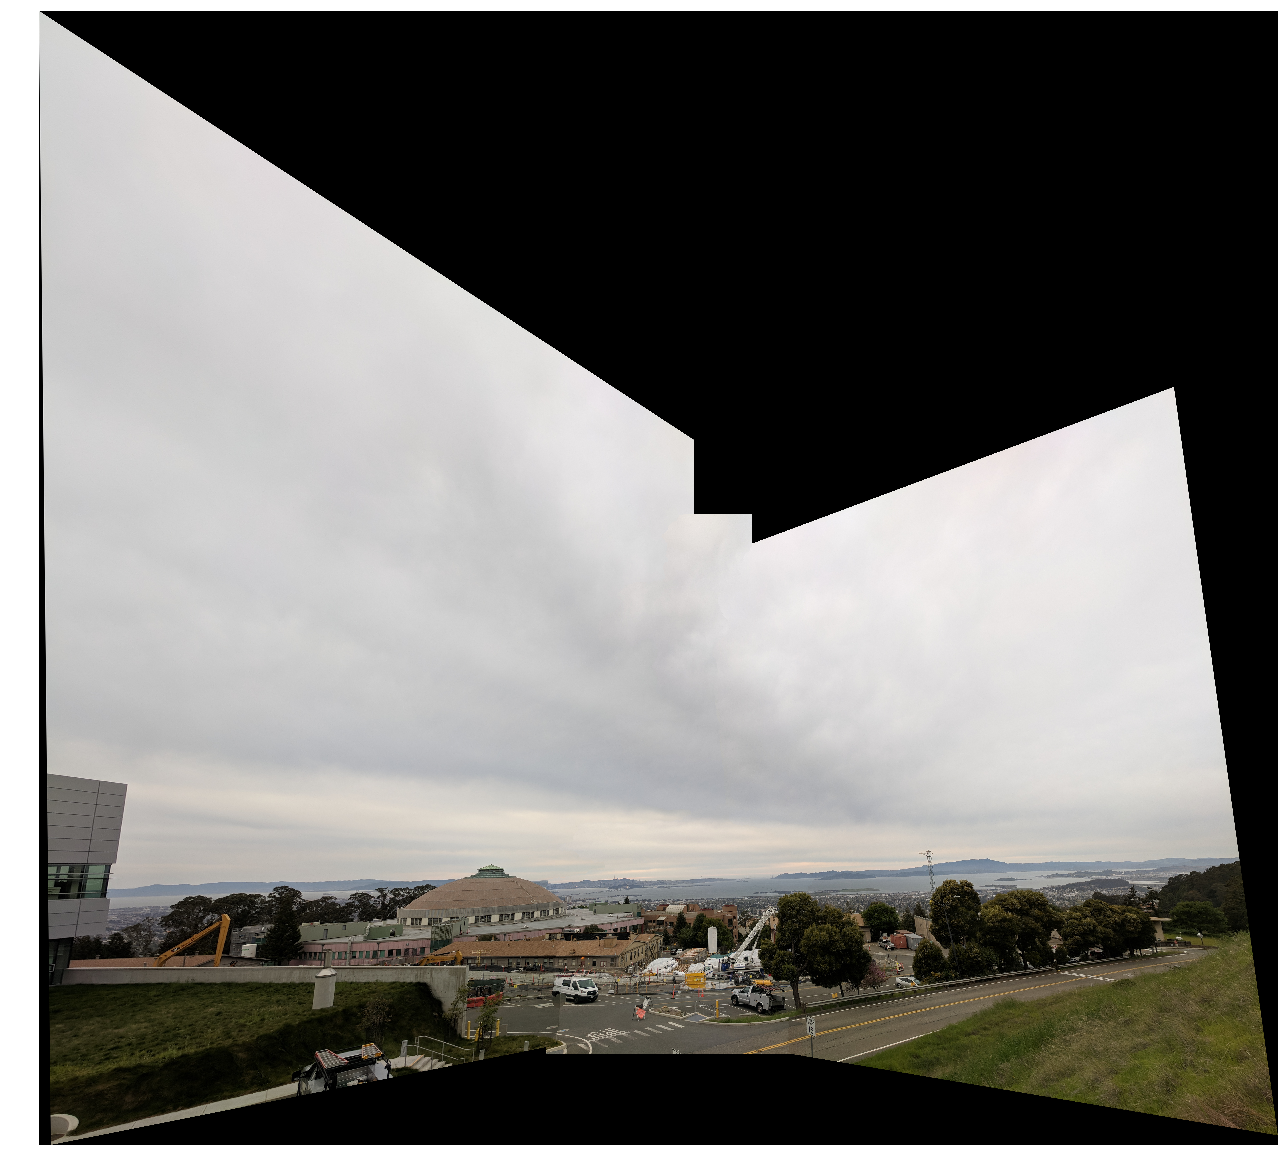

In [13]:
#identical transforms as before, except operating on color images and filling with cval=0 as we know the masks
sf_bay0_color = warp(bay_imgs[0], (model_robust01 + offset1).inverse, order = 3,
                   output_shape = output_shape, cval = 0)

sf_bay1_color = warp(bay_imgs[1], offset1.inverse, order = 3,
                   output_shape = output_shape, cval = 0)

sf_bay2_color = warp(bay_imgs[2], (model_robust12 + offset1).inverse, order = 3,
                   output_shape = output_shape, cval = 0)

sf_bay0_color = sf_bay0_color[:,:,0:3]
sf_bay1_color = sf_bay1_color[:,:,0:3]
sf_bay2_color = sf_bay2_color[:,:,0:3]

#start with empty image
sf_bay_combined = np.zeros_like(sf_bay0_color)

#place the masked portion of each image into the array - masks are 2d, need to be (M, N, 3) to match color images
sf_bay_combined += sf_bay0_color * gray2rgb(mask0)
sf_bay_combined += sf_bay1_color * gray2rgb(mask1)
sf_bay_combined += sf_bay2_color * gray2rgb(mask2)

#save the resulting color panorama
#the path in imsave() should reflect the location on your machine where you want to save the panorama to
io.imsave('/Users/danslaughter/Desktop/sf_bay_pano.png', sf_bay_combined)

#display the resulting color panorama
fig, ax = plt.subplots(figsize = (18, 18))
ax.imshow(sf_bay_combined, interpolation = 'none')
fig.tight_layout()
ax.axis('off');